We put together our work done for 2D-Laplace inside the 2D-Laplace-research.ipynb

In [1895]:
# Define methods
import math
import random
import numpy as np


#Define Lambda distribution
def LambertW(x):
	#Min diff decides when the while loop ends
	min_diff = 1e-10
	if (x == -1 / np.e):
		return -1
	elif ((x < 0) and (x > -1/np.e)):
		q = np.log(-x)
		p = 1
		while (abs(p-q) > min_diff):
			p = (q * q + x / np.exp(q)) / (q + 1)
			q = (p * p + x / np.exp(p)) / (p + 1)
		#determine the precision of the float number to be returned
		return (np.round(1000000 * q) / 1000000)
	elif (x == 0):
		return 0
	else:
		return 0

def inverseCumulativeGamma (eps, p): 
    x = (p - 1) / np.e
    return -(LambertW(x) + 1)/eps

def addVectorToPoint(point, distance, angle):
	x1, y1 = point
	x2 = x1 + (distance * np.cos(angle))
	y2 = y1 + (distance * np.sin(angle))
	return x2, y2
    
def generate_laplace_noise(eps, x, y): 
    theta = np.random.rand()*np.pi*2
    p = random.random()
    r = inverseCumulativeGamma(eps, p) # draw radius distance
    return addVectorToPoint([x, y], r, theta)


def calculate_radius_with_noise(x0, n, epsilon): 
    """
        x0: Point to perturb
        n: amount of points to generate
        epsilon: privacy budget
    """
    Z = []
    total_dis = 0
    for nm in range(0, n):
        x1, y1 = x0
        noise = generate_laplace_noise(epsilon, x1, y1)
        x2, y2 = noise
        total_dis = total_dis + math.dist(x0, noise)
        Z.append(noise)

    R = total_dis / n
    return np.array(Z), R
    

# ---------------------------------------------
# ----------------- TRUNCATION ----------------
def truncate(x_max, x_min, x0, z, epsilon): 
    """
    x_max: max domain point (x, y)
    x_min: min domain point (x, y)
    x0: point to truncate (radius centre)
    z: x0 + noise
    epsilon: privacy budget
    """
    x2, y2 = x_max
    x1, y1 = x_min

    zx, zy = z
    if(x1 < zx < x2 and y1 < zy < y2): 
        # print('inside', x, y)
        return z
    else:
        x, y = x0
        z2 = generate_laplace_noise(epsilon, x, y)
        return truncate(x_max, x_min, x0, z2, epsilon)

def truncate_array(x0, X, Z, epsilon): 
    truncatedZ1 = []
    x_max = [np.max(X[:, 0]), np.max(X[:, 1])]
    x_min = [np.min(X[:, 0]), np.min(X[:, 1])]
    for z in Z:
        truncatedZ1.append(truncate(x_max, x_min, x0, z, epsilon))

    return np.array(truncatedZ1)

In [1896]:
def generate_laplace_noise_for_point(x0, epsilon, doTruncate = True): 
    x_max = [np.max(X[:, 0]), np.max(X[:, 1])]
    x_min = [np.min(X[:, 0]), np.min(X[:, 1])]
    z, R = calculate_radius_with_noise(x0, 1, epsilon)
    if(doTruncate):
        z = truncate(x_max, x_min, x0, z[0], epsilon)
    return z

In [1897]:
def generate_truncated_laplace_noise(X, epsilon): 
    Z = []
    x_max = [np.max(X[:, 0]), np.max(X[:, 1])]
    x_min = [np.min(X[:, 0]), np.min(X[:, 1])]
    for x0 in X:
        z, R = calculate_radius_with_noise(x0, 1, epsilon)
        z = truncate(x_max, x_min, x0, z[0], epsilon)
        Z.append(z)
    return x_max, x_min, Z


## Experiment
1. We run three different experiments for r = 0.1, 0.2, 0.3. 0.4 with epsilons 20, 10, 6.6, 5.0
2. Visualize: We first will scatter each of epsilons to see the impact of this on the perturbed data. Based on this we are be-able to select a well suitable epsilon to use with point 3.
3. Visualize: We cluster using our baseline clusters, K-means, AP and DBSCAN. Using pairplots we show the normal data and the perturbed data besides eachother.
4. Measurement: We evaluate the differences using the scores metrics that can be used to assess the performance of cluster algorithms. For this purpose we juse the adjusted mutual information index.
4. Finally, we check how the algorithm performs for distributed data by splitting 10 different datasets between 10 - 15 samples and conduct point 4 again.

In [1898]:
radius= 0.3 # radius r, for now we divide the standard deviation by 2
levels = [2, 4, 6, 8] # privacy level l

epsilons = [l/radius for l in levels]
epsilons


[6.666666666666667, 13.333333333333334, 20.0, 26.666666666666668]

## Data 
We use synthetic generated data for this research question
1. We use 200 samples to illustrate sparsity of data
2. We generate two features (x, y)

In [1899]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=50, centers=4, n_features=2,
                       cluster_std=0.60, random_state=0)



## Visualize

In [1900]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [1901]:
sns.set()

labels = ['Dataset {}'.format(i) for i in range(1, len(epsilons)+1)]

df = pd.DataFrame()
for i in range(len(epsilons)):
    eps = epsilons[i]
    x_max, x_min, Z = generate_truncated_laplace_noise(X, eps)
    Z = np.array(Z)
    df['%d_X' % eps] = Z[:, 0]
    df['%d_Y' % eps] = Z[:, 1]
df['X'] = X[:, 0]
df['Y'] = X[:, 1]
df.head()

,6_X,6_Y,13_X,13_Y,20_X,20_Y,26_X,26_Y,X,Y
0,0.642135,4.793584,0.787485,4.736485,0.749945,4.740392,0.865445,4.523108,0.914339,4.550146
1,-2.166463,2.844160,-1.851435,2.515817,-1.909604,2.735988,-1.807333,2.715519,-1.930380,2.702150
2,1.884824,4.232632,1.907889,4.121027,1.848888,4.119479,1.854356,4.213392,1.872718,4.180692
3,-0.843089,4.958375,-0.607255,4.381432,-0.551822,4.659821,-0.447051,4.663664,-0.555524,4.695958
4,-1.158454,8.083694,-1.021176,8.150540,-1.011794,8.229506,-1.045500,8.385054,-1.034436,8.259404


<AxesSubplot:xlabel='X', ylabel='Y'>

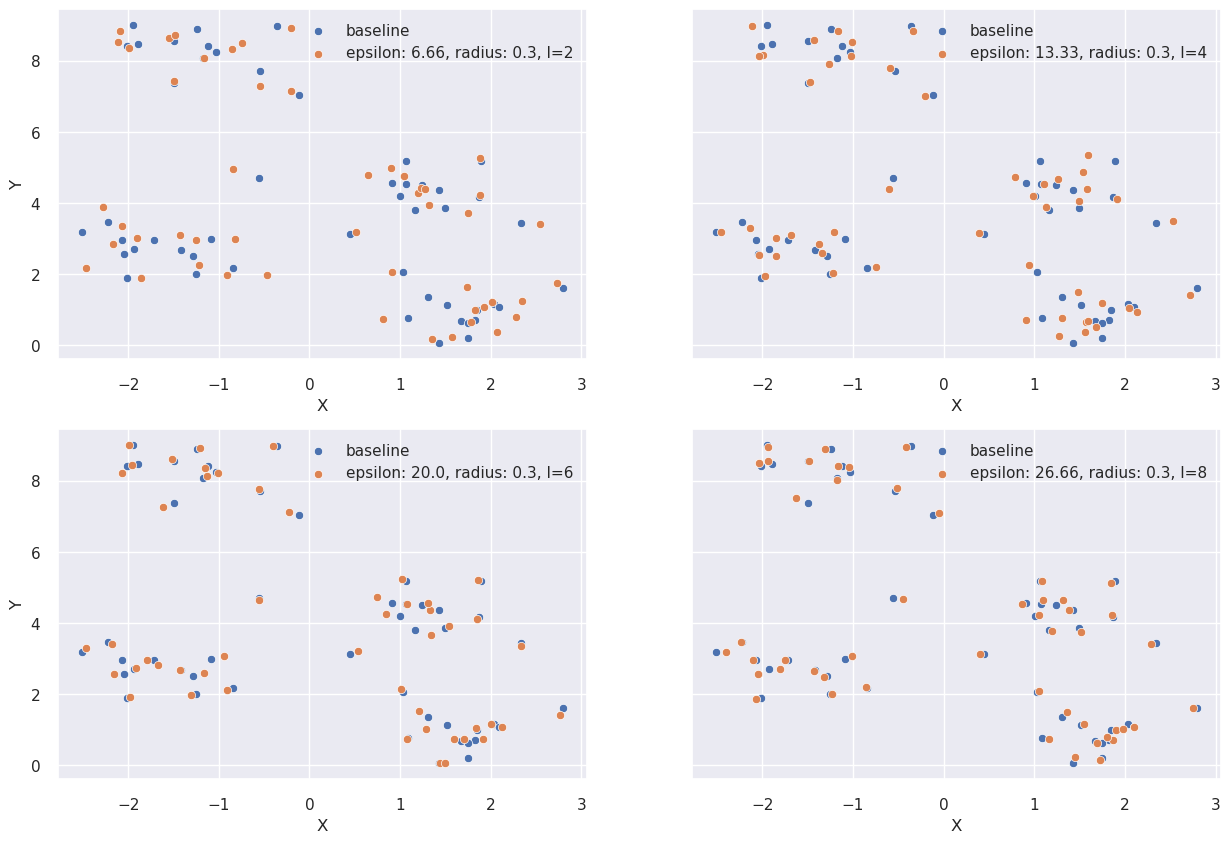

In [1902]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
sns.scatterplot(data=df, x='X', y='Y', ax=axes[0,0], label='baseline')
sns.scatterplot(data=df, x='6_X', y='6_Y', ax=axes[0,0], label='epsilon: 6.66, radius: 0.3, l=2')

sns.scatterplot(data=df, x='X', y='Y', ax=axes[0,1], label='baseline')
sns.scatterplot(data=df, x='13_X', y='13_Y', ax=axes[0,1], label='epsilon: 13.33, radius: 0.3, l=4')

sns.scatterplot(data=df, x='X', y='Y', ax=axes[1,0], label='baseline')
sns.scatterplot(data=df, x='20_X', y='20_Y', ax=axes[1,0], label='epsilon: 20.0, radius: 0.3, l=6')

sns.scatterplot(data=df, x='X', y='Y', ax=axes[1,1], label='baseline')
sns.scatterplot(data=df, x='26_X', y='26_Y', ax=axes[1,1], label='epsilon: 26.66, radius: 0.3, l=8')


So logically, a higher privacy level $l$, yields less accurate results; but provides more privacy. 

## Clustering
Based on the results it is notably visible that $r=0.3$, $l=4$ and $\epsilon=13.33$ has a very high similarity to the original data. A little to high regarding the trade-off between utillity and privacy. It is also worth to mention that the last two scatterplots seem to much off. Therefore, based on visual inspection the second one has a good utillity / privacy trade-off.
- r = 0.3
- l = 13.33
- epsilon = l\r 

In [1903]:
r = 0.3
l = 4
epsilon = l/r
epsilon

13.333333333333334

In [1904]:
df2 = df.loc[:, ['X', 'Y', '13_X', '13_Y']]
df2.head()

,X,Y,13_X,13_Y
0,0.914339,4.550146,0.787485,4.736485
1,-1.930380,2.702150,-1.851435,2.515817
2,1.872718,4.180692,1.907889,4.121027
3,-0.555524,4.695958,-0.607255,4.381432
4,-1.034436,8.259404,-1.021176,8.150540


### Preprocessing
For the actual clustering we need a pre-processing stap which is scaling (to make sure the data is on the same scale)

In [1905]:
from sklearn.preprocessing import StandardScaler

plainDf = df2.loc[:, ['X', 'Y']]
plainDf_scaled = pd.DataFrame(StandardScaler().fit_transform(plainDf), columns=['X', 'Y'])

perturbedDf = df2.loc[:, ['13_X', '13_Y']]
perturbedDf_scaled = pd.DataFrame(StandardScaler().fit_transform(perturbedDf), columns=['X', 'Y'])

### K-means

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff1e79ee50>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff1e79ee50>
Traceback 

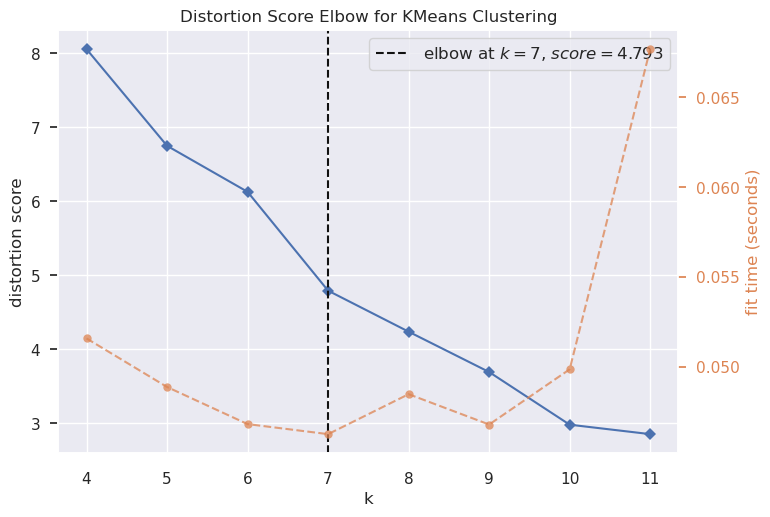

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [1906]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


model = KMeans(init='random')
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(plainDf_scaled.loc[:, ['X', 'Y']])        # Fit the data to the visualizer
visualizer.show()

In [1907]:
from sklearn.cluster import KMeans

n_clusters = visualizer.elbow_value_ # as determined using a elbowplot

def calculate_kmeans(df): 
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init="random")
    y_kmeans = kmeans.fit(df)
    return y_kmeans
    
def plot_kmeans(df, fitted_algo, ax):
    labels = fitted_algo.labels_
    centroids = fitted_algo.cluster_centers_ if hasattr(fitted_algo, 'cluster_centers_') else df.groupby(labels).mean().to_numpy()
    sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:,1], ax=ax, hue=labels)
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], ax=ax, s=100)
    #centers.iloc[:, 0], centers.iloc[:, 1]
def plot_algorithm (plainDf, perturbedDf, algorithmPlain, algorithmPerturbed,algorithmName): 
    fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharey=True, sharex=True)
    fig.suptitle('%s (r=%.2f, l=%.2f, $\epsilon$=l/r=%d)' % (algorithmName, r, l,epsilon))
    axes[0].set_title('Plain data')
    plot_kmeans(plainDf,algorithmPlain, axes[0])
    axes[1].set_title('Perturbed data')
    plot_kmeans(perturbedDf,algorithmPerturbed, axes[1])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff1e438940>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff1e438940>
Traceback 

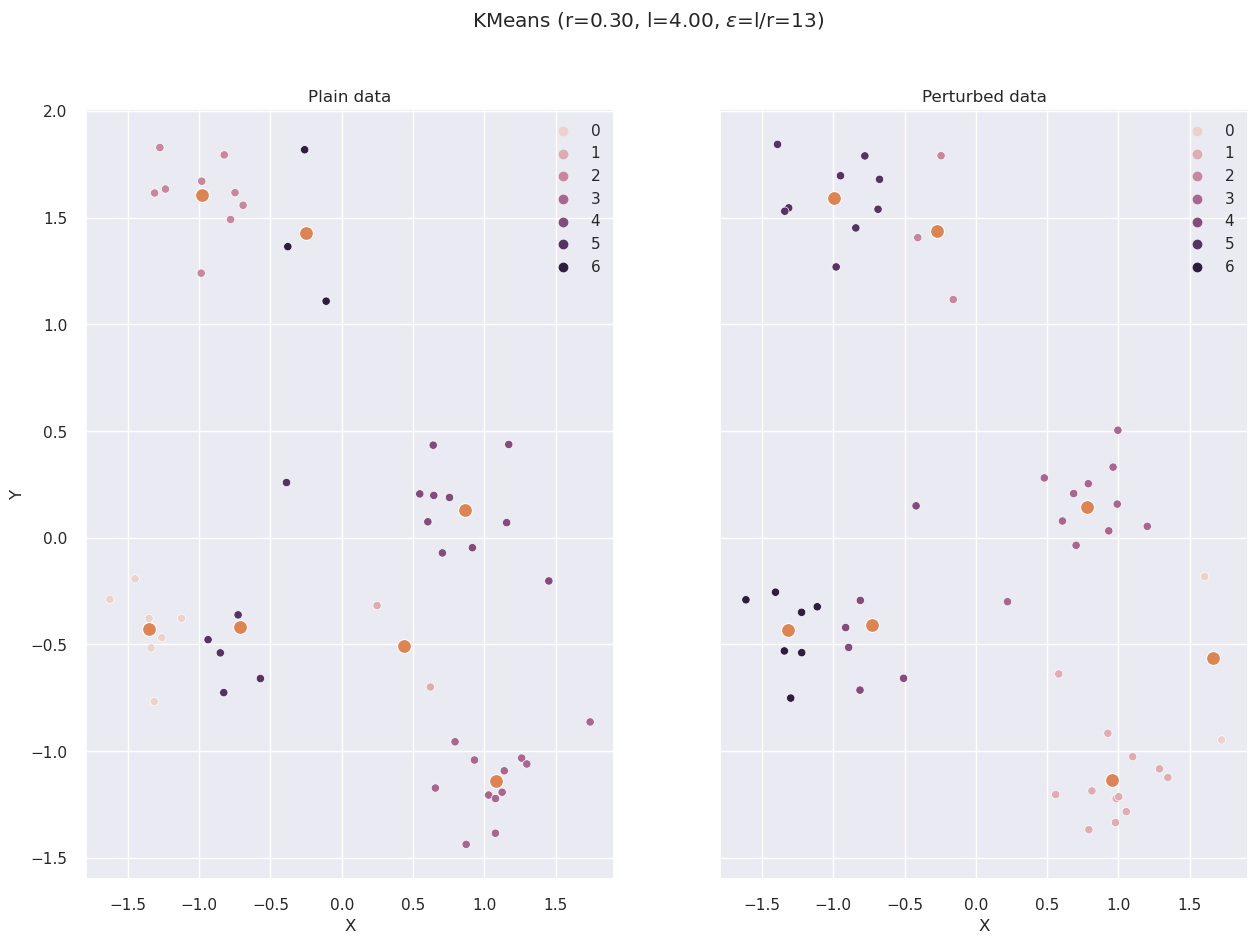

In [1908]:
kmeans_fitted_plain = calculate_kmeans(plainDf_scaled)
kmeans_fitted_perturbed = calculate_kmeans(perturbedDf_scaled)
plot_algorithm(plainDf_scaled, perturbedDf_scaled, kmeans_fitted_plain, kmeans_fitted_perturbed, 'KMeans')

### Affinity propagation

In [1909]:
from sklearn.cluster import AffinityPropagation

def fit_ap(dataframe):
    ap = AffinityPropagation(affinity='euclidean', random_state=0).fit(dataframe)
    return ap

def scatter_ap(dataframe, fitted_ap, ax): 
    centroids = fitted_ap.cluster_centers_
    labels =fitted_ap.labels_
    sns.scatterplot(x=dataframe.iloc[:, 0], y=dataframe.iloc[:,1], ax=ax, hue=labels)
    sns.scatterplot(centroids[:, 0], centroids[:, 1], s=100, ax=ax)

def ap_and_plot(df): 
    fitted_ap = fit_ap(df)
    scatter_ap(df, fitted_ap)

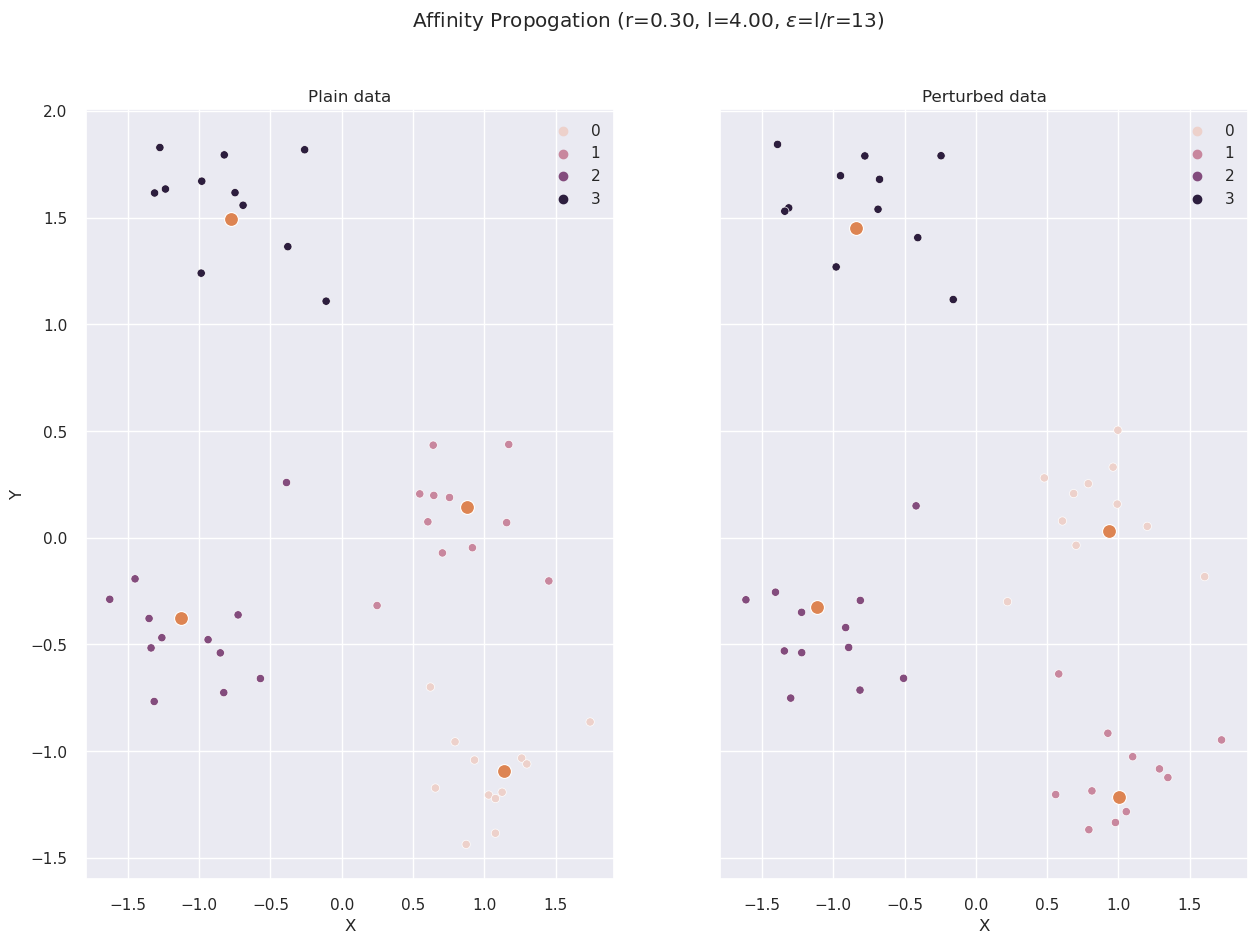

In [1910]:
# fig.suptitle('Affinity Propogation (r=%.2f, l=%.2f, $\epsilon$=l/r=%d)' % (r, l,epsilon))
fitted_ap_plain = fit_ap(plainDf_scaled)
fitted_ap_perturbed = fit_ap(perturbedDf_scaled)

plot_algorithm(plainDf_scaled, perturbedDf_scaled, fitted_ap_plain, fitted_ap_perturbed, 'Affinity Propogation')

### DBSCAN

In [1911]:
from sklearn.cluster import DBSCAN


def fit_dbscan(df):
    dbscan = DBSCAN(eps=0.3, min_samples=5, metric='euclidean')
    dbscan.fit(df)

    labels = dbscan.labels_
    centers = df.groupby(labels).mean()
    return dbscan

def scatter_dbscan(df, labels, centers): 
    sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:,1],hue=labels)
    plt.scatter(centers.iloc[:, 0], centers.iloc[:, 1], s=100, c='r')
    plt.show()


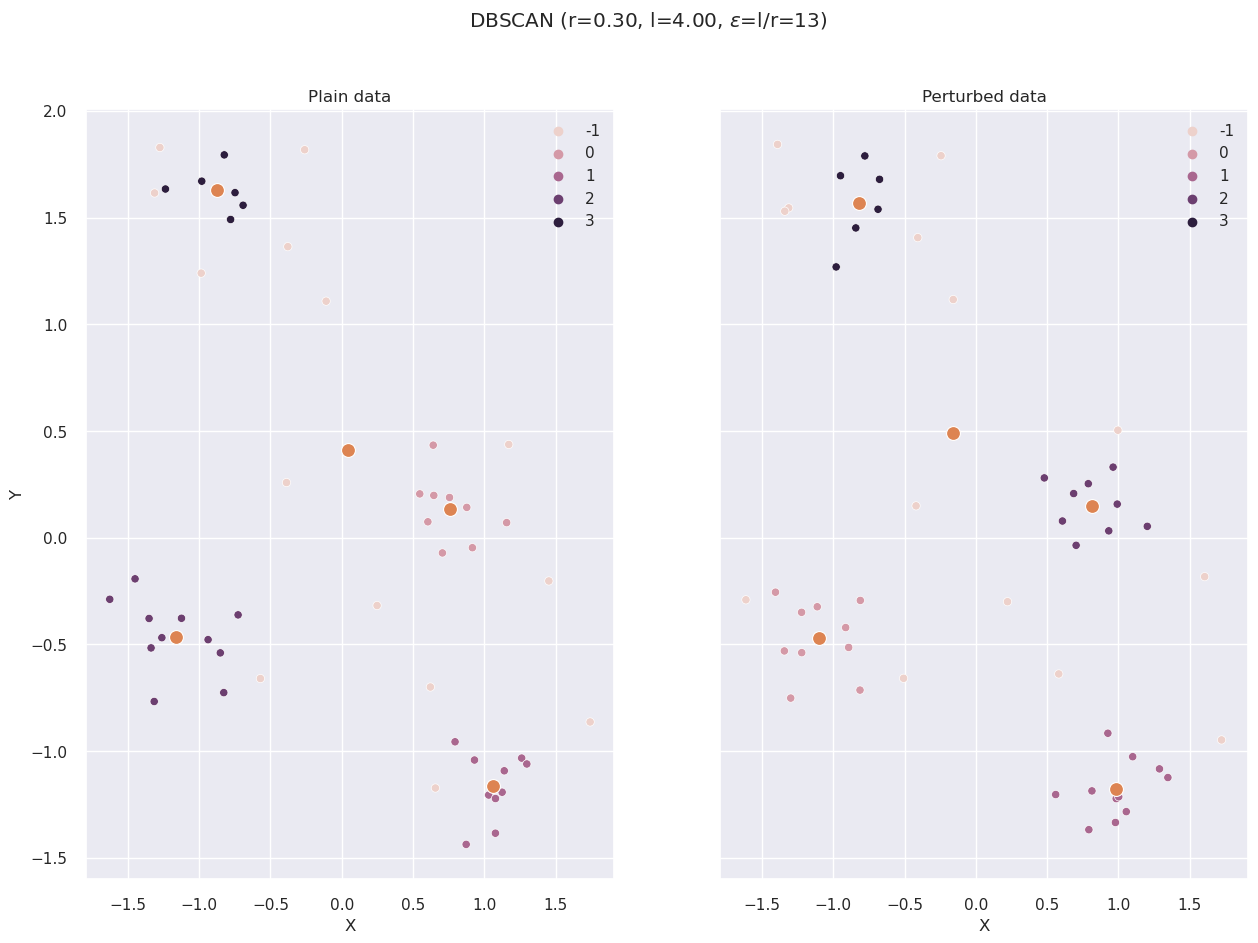

In [1912]:
dbscan_fitted_plain = fit_dbscan(plainDf_scaled)
dbscan_fitted_perturbed = fit_dbscan(perturbedDf_scaled)

plot_algorithm(plainDf_scaled, perturbedDf_scaled, dbscan_fitted_plain, dbscan_fitted_perturbed, 'DBSCAN')

## Measurement

It is often hard to evaluate the performance of clustering by the human eye.
Therefore, we will use a metric to evaluate cluster performance between baseline and perturbed clustering.
To this end we compare these two using a silhouette coefficient.
- For silhouette score higher is better (The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster) See: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


In [1913]:
from sklearn import metrics

## KMeans
metrics_kmeans_silhouette_score_plain = metrics.silhouette_score(plainDf, kmeans_fitted_plain.labels_, metric='euclidean')
metrics_kmeans_silhouette_score_perturbed = metrics.silhouette_score(perturbedDf, kmeans_fitted_perturbed.labels_, metric='euclidean')

# AP
metrics_ap_silhouette_score_plain = metrics.silhouette_score(plainDf, fitted_ap_plain.labels_, metric='euclidean')
metrics_ap_silhouette_score_perturbed = metrics.silhouette_score(perturbedDf, fitted_ap_perturbed.labels_, metric='euclidean')

# DBSCAN
#metrics_dbscan_silhouette_score_plain = metrics.silhouette_score(plainDf, dbscan_fitted_plain, metric='euclidean')
#metrics_dbscan_silhouette_score_perturbed = metrics.silhouette_score(perturbedDf, dbscan_fitted_perturbed, metric='euclidean')


In [1914]:
print(metrics_kmeans_silhouette_score_plain, metrics_kmeans_silhouette_score_perturbed, metrics_kmeans_silhouette_score_plain - metrics_kmeans_silhouette_score_perturbed)
print(metrics_ap_silhouette_score_plain, metrics_ap_silhouette_score_perturbed, metrics_ap_silhouette_score_plain - metrics_ap_silhouette_score_perturbed)
#print(metrics_dbscan_silhouette_score_plain, metrics_dbscan_silhouette_score_perturbed, metrics_dbscan_silhouette_score_plain - metrics_dbscan_silhouette_score_perturbed)

0.4406937795817193 0.40858160548001377 0.032112174101705526
0.6931936171890376 0.6958951440158556 -0.0027015268268180126


In [1915]:
metrics_kmeans_ci_score_plain = metrics.calinski_harabasz_score(plainDf, kmeans_fitted_plain.labels_)
metrics_kmeans_ci_perturbed = metrics.calinski_harabasz_score(perturbedDf, kmeans_fitted_perturbed.labels_)


In [1916]:
print(metrics_kmeans_ci_score_plain, metrics_kmeans_ci_perturbed, metrics_kmeans_ci_score_plain - metrics_kmeans_ci_perturbed)


153.78610683445064 142.94925840947562 10.836848424975017


In [1917]:
epsilons

[6.666666666666667, 13.333333333333334, 20.0, 26.666666666666668]

Considering the definition dp (K(x), K(x′)) ≤ ϵd(x, x′). Being K(x) the perturbed value of $x \in X$

In [1918]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist

matrix_perturbed = pdist(perturbedDf)

matrix_plain = pdist(plainDf)
print(matrix_plain.size, plainDf.size)

1225 100


In [1919]:
i = 0
objs = []
for obj in matrix_plain:
    objs.append(epsilons[1] * obj)
    i += 1
matrix_plain <= objs

array([ True,  True,  True, ...,  True,  True,  True])

We are be-able to find a privacy level given a the prior knowledge of an attacker guessing the right location.
Assume that an attacker has taken control of the perturbed dataset.
Calculate the probability that the attacker correctly identifies the location of the target individual from the perturbed dataset. This probability is the identification probability.
This is then repeated multiple times to take the average identification probability.


### Evaluation of utility level
We evaluate two parts:
- Cluster quality loss using the centroids calculated.
- Perturbation quality loss using the unperturbed data versus the perturbed data.
#### Evalution of cluster algorithm performance.
The Relative Error (RE) can be used to measure the error between the non-private K-Means centroids and that from the nD-Laplace version. (Xia et al., Huang et al.). 
Also the Normalized Mutual Information (NMI) metric can be used for evaluating the accuraccy (Xia et al, Sun et al. 2022, ). <br>
For Relative Error the metric is given as: <br><br> (Bron)
$RE = \frac{1}{K} \sum{\frac{`c_i - c_i}{c_i}}$ 
<br>
Huang et al. uses a similar methodology by mearuring the relative error, but uses the adjusted Mutual Information score instead of the normalized one. <br>
<b>Consider AMI vs NMI</b>

The measurement is executed $K$ times for each privacy budget and the avarage is reported (Huang et al.).
The RE and NMI measurements require the ground truth labels, which are typically unknown for a unsupervised machine learning problem.
Therefore, a common way to achieve aquire these labels is to estimate them using the non-private version of the cluster algorithm.
This approach is based on similar work (Xia et al.).

#### Setup
In line with the existing cluster algorithms we use the non-private variant centroids of a cluster algorithm as ground truth.
This is then compared using a line-plot where the Y-axis displays the AMI/RE and the X-axis shows the epsilon.
If we consider different algorithms, then the different colors of the lines are used to visualize the different algorithms. <br>
Experiment setup:
1. Condider the set with points (x,y) for $x \in X$
2. Apply the PL algorithm for every x so we get $z \in Z$.
3. For any cluster algorithm fit X and fit Z. So we get ground truths $c_i \in C$ where C is the set of centroids produced by the non-private algorithm.
4. Calculate RME between every centroid.
5. Calculate AMI between every centroid.
6. Wrap this with a method that runs this 10 times.
7. Take the average RE, AMI
8. Rerun for next epsilon



In [1920]:
from sklearn.metrics import mean_squared_error, adjusted_mutual_info_score, pairwise
from sklearn.base import clone
def calculate_ami_for_algorithm(X, X_scaled, epsilon, algorithm):
    _, _, Z = generate_truncated_laplace_noise(X, epsilon)
    Z = np.array(Z)
    perturbed_scaled = pd.DataFrame(StandardScaler().fit_transform(Z), columns=['X', 'Y'])
    ap_nonprivate = algorithm.fit(X_scaled)
    private_ap = clone(algorithm).fit(perturbed_scaled)
    return adjusted_mutual_info_score(ap_nonprivate.labels_, private_ap.labels_)

def get_avg_ami_and_re(X, epsilon, n_times=10):
    scores = {'kmeans': [], 'dbscan': [], 'ap': [], 'RE_metric': []}
    plainDf_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=['X', 'Y'])
    ## algorithmName = type(algorithm).__name__
    """if algorithmName == "KMeans":
        model = KMeans(init='random')
        elbow_method = KElbowVisualizer(model, k=(4,12))
        elbow_method.fit(plainDf_scaled.loc[:, ['X', 'Y']])
        n_clusters = visualizer.elbow_value_
        algorithm = KMeans(n_cluster=n_clusters, init="random") """
    
    for i in range(n_times): 
        ap = AffinityPropagation(affinity='euclidean')
        kmeans = KMeans(init="random", n_clusters=8)
        dbscan = DBSCAN(metric="euclidean")
        scores['ap'].append(calculate_ami_for_algorithm(X, plainDf_scaled, epsilon, ap))
        scores['kmeans'].append(calculate_ami_for_algorithm(X, plainDf_scaled, epsilon, kmeans))
        scores['dbscan'].append(calculate_ami_for_algorithm(X, plainDf_scaled, epsilon, dbscan))
        
    return (np.sum(scores['ap']) / n_times), (np.sum(scores['kmeans']) / n_times), (np.sum(scores['dbscan']) / n_times)

def get_re_score(X, epsilon, n_times=10):
    scores = []
    for i in range(n_times):
        _, _, Z = generate_truncated_laplace_noise(X, epsilon)
        Z = np.array(Z)
        scores.append(mean_squared_error(X, Z))
    return np.sum(scores) / n_times

def run_experiments_for_epsilons(X, epsilons):
    scores = { 'KMeans': [], 'AffinityPropagation': [], 'DBSCAN': [], 'epsilon': []}
    # algorithmName = type(algorithm).__name__
    for eps in epsilons:
        ap_ami, kmeans_ami, dbscan_ami = get_avg_ami_and_re(X, eps)
        scores['epsilon'].append(eps)
        scores['KMeans'].append(kmeans_ami)
        scores['AffinityPropagation'].append(ap_ami)
        scores['DBSCAN'].append(dbscan_ami)
    
    return pd.DataFrame(scores)

def run_RE_experiment_for_epsilons(X, epsilons):
    scores = { 'epsilon': [], 're': []}
    for eps in epsilons:
        scores['epsilon'].append(eps)
        scores['re'].append(get_re_score(X, eps))
        
    return pd.DataFrame(scores)

In [1921]:
experiment_epsilons = [0.5, 1, 1.5, 2, 2.5, 3]

In [1922]:
utility_ami = run_experiments_for_epsilons(X, experiment_epsilons)
utility_ami

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff1e41c8b0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff1e41c8b0>
Traceback 

,KMeans,AffinityPropagation,DBSCAN,epsilon
0,0.104561,0.181018,0.100616,0.5
1,0.306333,0.440221,0.298281,1.0
2,0.482491,0.568026,0.451550,1.5
3,0.548219,0.744641,0.651700,2.0
4,0.611766,0.861561,0.708507,2.5
5,0.664435,0.869831,0.799928,3.0


In [1923]:
utility_ami_melted = utility_ami.melt(id_vars=['epsilon'])
utility_ami_melted.head()

,epsilon,variable,value
0,0.5,KMeans,0.104561
1,1.0,KMeans,0.306333
2,1.5,KMeans,0.482491
3,2.0,KMeans,0.548219
4,2.5,KMeans,0.611766


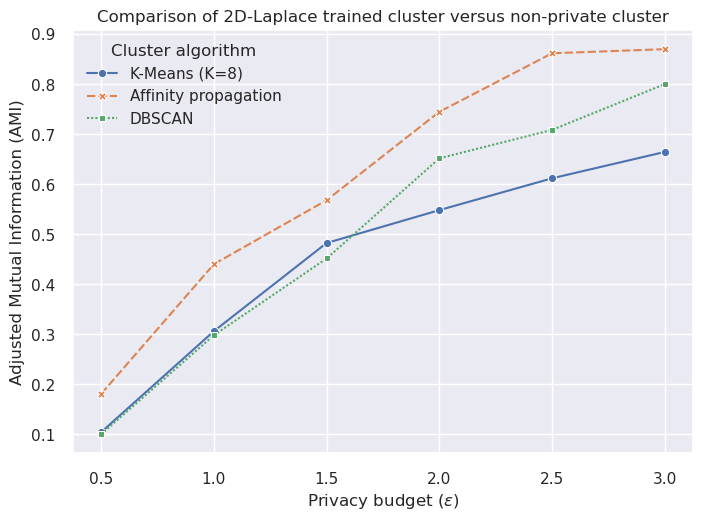

In [1924]:
ax = sns.lineplot(x='epsilon', y='value', data=utility_ami_melted, style="variable", hue="variable", markers=True, legend=True)
ax.set_xticks(experiment_epsilons)
ax.set_title('Comparison of 2D-Laplace trained cluster versus non-private cluster')
ax.set_xlabel('Privacy budget ($\epsilon$)')
ax.set_ylabel('Adjusted Mutual Information (AMI)')
plt.legend(title='Cluster algorithm', loc='upper left', labels=['K-Means (K=8)', 'Affinity propagation', 'DBSCAN'])


In [1925]:
re_score_df = run_RE_experiment_for_epsilons(X, experiment_epsilons)
re_score_df

,epsilon,re
0,0.5,3.956363
1,1.0,1.870894
2,1.5,0.846719
3,2.0,0.592149
4,2.5,0.368825
5,3.0,0.254226


Text(0, 0.5, 'Relative error')

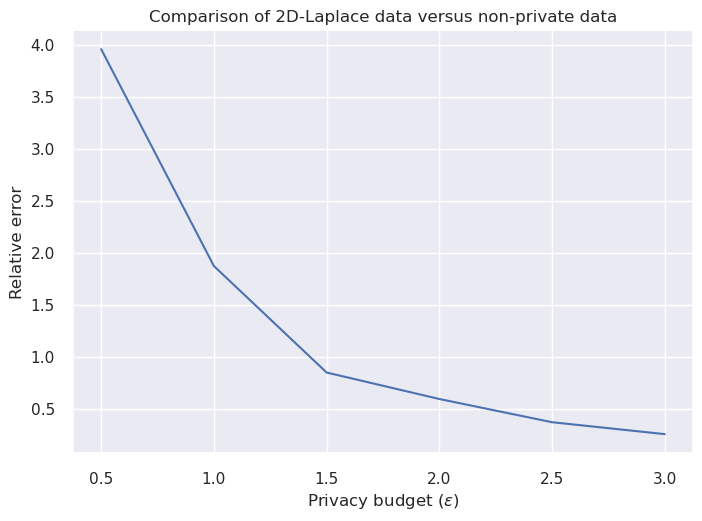

In [1926]:
ax = sns.lineplot(x='epsilon', y='re', data=re_score_df, markers=True, legend=True)
ax.set_title('Comparison of 2D-Laplace data versus non-private data')
ax.set_xlabel('Privacy budget ($\epsilon$)')
ax.set_ylabel('Relative error')

We compare the service quality loss using the paper provided by (Yan, Yan).
This algorithm calculates the service quality by calculating the loss between the normal data and the perturbed data.

- Using mean: $M_{dis} = \frac{1}{N} * \sum\limits_{i=1}^N{dis(x_i, x`_i)}$
- Using variance: $V_{dis} = \frac{1}{N} * \sum\limits_{i=1}^N{(dis_i - M_{dis})^2}$

### Proof privacy level
So based on the clustering and error results $\epsilon 2.5 / 3$ give preserve the most utility.
As we do not consider geographical data it is hard to tell if our data really preserves $\epsilon$-geo-indistuinghability. 
Therefore, we adopt a more general notion which is used for exactly this purpose: $d_x$-privacy (m.alvimInvitedPaperLocal2018a).
<br>
Assume a adversary has access to the perturbed data.
We calculate the chance for every perturbed point that a adversiary guesses a location right.


In [1927]:
from scipy.stats import gamma, uniform
    
def compute_theta():
    return 1/(2*np.pi)
def compute_d_radius(eps):
    return gamma(2, scale=eps)

In [2087]:
level = 3
radius = 5
temp_eps = level/radius
temp_eps

0.6

K(x1)(x) represents the probability that the perturbed location belongs to the set x ∈Z, while the user’s actual location is x1. (3D geo)

$$ P(z | x) = \frac{P(x | z)P(z)}{\sum_{z'\in Z} P(x | z')P(z')} \cdot \exp \left(-\frac{\lambda \cdot d(x, z)}{b} \right) $$



In [2071]:
x_max, x_min, Z = generate_truncated_laplace_noise(X, temp_eps)
Z = np.array(Z)
P_X = np.ones(len(X)) / len(X)
P_Z = np.ones(len(Z)) / len(Z)

$K(x)(y)≤ e^{\epsilon⋅d(x,x′)} * K(x′)(y)$.

In [2072]:
def kernel(x, y, sigma = 0.1):
    return np.exp(-np.linalg.norm(x - y)**2 / (2*sigma**2))

In [2073]:
print(kernel(X[3], Z[3]), X[1], Z[1])

1.4760881100838204e-34 [-1.93038028  2.70215036] [1.31747404 3.82053392]


In [2074]:
def measure_privacy(point_x, point_x_prime, temp_eps): 

    z_of_x =  generate_laplace_noise_for_point(point_x, temp_eps, False)
    z_of_x_prime =  generate_laplace_noise_for_point(point_x_prime, temp_eps, False)
    upperbound = np.exp(np.multiply(temp_eps, dist.euclidean(point_x, point_x_prime))) * kernel(point_x_prime, z_of_x_prime)
    print(upperbound, kernel(point_x_prime, z_of_x_prime))
    return kernel(point_x, z_of_x) <= upperbound

In [2075]:
def measure_privacy_2(X, temp_eps): 
    resp = []
    for i, x in enumerate(X):
        for j, x_prime in enumerate(X[i+1:], i+1):
            z_of_x =  generate_laplace_noise_for_point(x, temp_eps, False)
            z_of_x_prime =  generate_laplace_noise_for_point(x_prime, temp_eps, False)
            K_x_z = kernel(x, z_of_x)
            K_x_prime_z = kernel(x_prime, z_of_x_prime)
            d_x_x_prime = dist.euclidean(x, x_prime)
            expected_privacy_loss =  np.exp(epsilon * d_x_x_prime) * K_x_prime_z
            resp.append(K_x_z <= expected_privacy_loss)
    return resp


In [2129]:
level = 3
radius = 0.2
temp_eps = level/radius
temp_eps
preserve = radius * temp_eps
print(preserve, radius, temp_eps)

3.0 0.2 15.0


In [2133]:
np.all(measure_privacy_2(X, temp_eps))

False

In [2078]:
def check_if_holds(temp_eps, preserve):
    holds = []
    does_not_hold = []
    for i in range(len(X)):
        does_hold = measure_privacy(X[i], np.add(X[i], 0.01), temp_eps)
        not_hold = measure_privacy(X[i], np.add(X[i], preserve+1), temp_eps)
        holds.append(does_hold)
        does_not_hold.append(not_hold);

    print(np.all(holds), np.all(does_not_hold))

In [2079]:
check_if_holds(temp_eps, preserve)

1.3116394855585393e-124 1.3005569412107666e-124
0.4595501087530875 0.015427250162096881
4.935652090403081e-151 4.8939488756254494e-151
2.2102683827755864e-20 7.419944553809913e-22
1.0151172064397072e-56 1.0065400923908993e-56
2.763415336240351e-176 9.276877294106071e-178
1.2529672723830868e-35 1.2423804720348338e-35
0.0 0.0
4.701949817717012e-162 4.662221242945065e-162
3.2565266870052146e-197 1.09322685172004e-198
1.1560492311902354e-46 1.1462813284898843e-46
5.399678540079455e-86 1.8126900646098939e-87
0.0 0.0
3.196075739070368e-31 1.072933267221557e-32
0.0 0.0
3.912155935020119e-124 1.3133237732539622e-125
0.0 0.0
4.193003542507623e-29 1.4076052501943592e-30
0.0 0.0
0.0 0.0
0.0 0.0
1.575337459994687e-177 5.2884603054502106e-179
0.0 0.0
6.05903854470529e-158 2.0340394135599875e-159
1.4922259120077847e-42 1.479617523781595e-42
8.746254770526555e-119 2.936146847891259e-120
1.0665573994874163e-36 1.0575456475468815e-36
9.589436512436468e-148 3.219205766098281e-149
2.559000392531906e-135 

So based on the definition of geo-I, we can only provide geo-indistinguishability if every point $x \in X$ is atleast of $l = r*\epsilon$ distance with other point $x'$.
This is because the definition $d(x, x') <= r$ not holds. 
Which means, we're be-able to calculate a better radius that provides geo-indistinguishability for the whole set by finding the minumum distance based on the equation $(x, x') <= r

In [2103]:
from scipy.spatial import distance
radius = distance.pdist(X).min()
level = 4
temp_eps = level/radius
print(radius, temp_eps)

0.08739771492910296 45.76778698670555


In [2081]:
preserve = radius * temp_eps
preserve


4.0

In [2082]:
holds = []
temp_eps = 18
for i in range(len(X)):
    does_hold = measure_privacy(X[i], np.add(X[i], 0.2), temp_eps)
    holds.append(does_hold)

print(np.all(holds))

148.40144094092474 0.9127915077332975
126.82128631886106 0.7800557219505134
130.84987278383716 0.8048348581238811
1.2393047531040269 0.007622748451460001
61.60424123915004 0.3789169962698336
48.19349600077704 0.2964298297817714
142.2285500069427 0.8748231269212439
7.824922280382058 0.04812973890899812
129.3787681023736 0.7957863485426242
36.58693905400386 0.22503991235330914
79.98065041527923 0.4919470998338581
151.35016790340853 0.9309286155195422
51.715910305869805 0.3180955888473255
96.02701857055685 0.5906455254638975
114.25483577142367 0.7027616655766458
137.5245802137262 0.8458898251105746
113.11346879612816 0.6957413153991028
12.644351858837297 0.07777321382029605
154.58378364162232 0.9508180247220512
136.47781050678222 0.8394513263130374
148.5563273520137 0.9137441871669273
162.01808776514292 0.996545139141084
119.33221704894568 0.7339917566206483
120.97527070120988 0.7440978944790643
144.36131699826092 0.8879414065370327
9.176038715687648 0.05644022161244284
27.78357612161479 